## Set-up and data loading

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact

from lib import data, visualization

sns.set()

%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data.download_data()

The data is already downloaded.


In [13]:
header, dtype_dict = data.get_data_header_and_dtypes()
learn_df = pd.read_csv(
    "data/us_census_full/census_income_learn.csv",
    names=header,
    usecols=[i for i in range(42) if i != 24],
    dtype=dtype_dict,
    sep=", ",
)
test_df = pd.read_csv(
    "data/us_census_full/census_income_test.csv",
    names=header,
    usecols=[i for i in range(42) if i != 24],
    dtype=dtype_dict,
    sep=", ",
)

/tmp/ipykernel_5455/1982936620.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  learn_df = pd.read_csv(
/tmp/ipykernel_5455/1982936620.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_df = pd.read_csv(


In [14]:
numerical_cols = list(learn_df.columns[learn_df.dtypes == int])
categorical_cols = list(learn_df.columns[learn_df.dtypes == "category"])

## Exploratory data analysis

In [15]:
print(f"Entries in learn data: {len(learn_df)}")
print(f"Entries in test data: {len(test_df)}")

Entries in learn data: 199523
Entries in test data: 99762


In [43]:
print("Proportions of missing values:")
missing_values = pd.concat(
    [(learn_df == "?").sum() / len(learn_df), (test_df == "?").sum() / len(test_df)],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
missing_values[missing_values.sum(axis=1) > 0]

Proportion of missing values:


,learn,test
state of previous residence,0.003548,0.003308
migration code-change in msa,0.499672,0.500652
migration code-change in reg,0.499672,0.500652
migration code-move within reg,0.499672,0.500652
migration prev res in sunbelt,0.499672,0.500652
country of birth father,0.033645,0.034372
country of birth mother,0.030668,0.030793
country of birth self,0.017006,0.017682


In [41]:
print("Proportions of unknown values:")
unknown_values = pd.concat(
    [
        learn_df.isin(["Not in universe", "Do not know", "NA"]).sum() / len(learn_df),
        test_df.isin(["Not in universe", "Do not know", "NA"]).sum() / len(test_df),
    ],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
unknown_values[unknown_values.sum(axis=1) > 0]

Proportions of unknown values:


,learn,test
class of worker,0.502423,0.501985
enroll in edu inst last wk,0.936950,0.936469
major occupation code,0.504624,0.504030
hispanic origin,0.001534,0.001403
member of a labor union,0.904452,0.904984
reason for unemployment,0.969577,0.968625
region of previous residence,0.920946,0.922876
state of previous residence,0.920946,0.922876
migration code-change in msa,0.007598,0.007247
migration code-change in reg,0.007598,0.007247


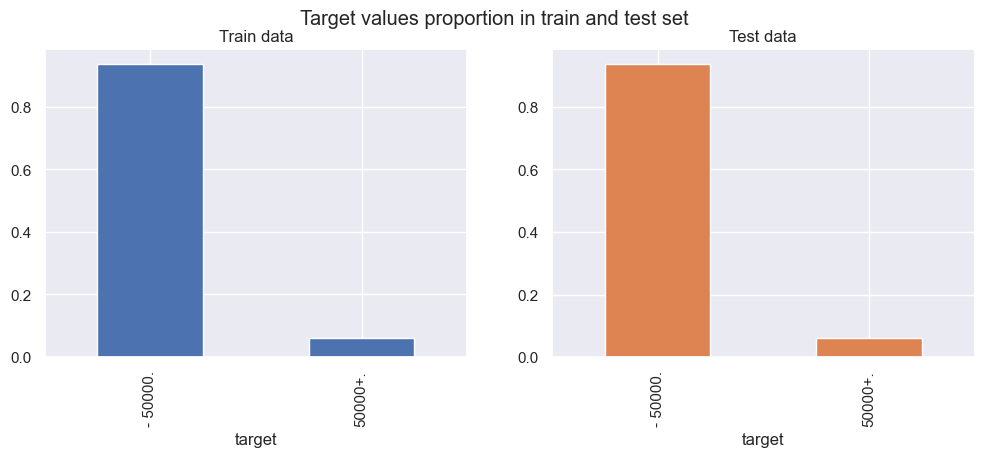

In [18]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

(learn_df["target"].value_counts() / len(learn_df)).plot.bar(ax=axs[0])
(test_df["target"].value_counts() / len(test_df)).plot.bar(ax=axs[1], color="C1")

axs[0].set_title("Train data")
axs[1].set_title("Test data")
plt.suptitle("Target values proportion in train and test set")
plt.show()

In [19]:
learn_df["set"] = "learn"
test_df["set"] = "test"
learn_test_df = pd.concat([learn_df, test_df])
# train_test_df["target"] = train_test_df["target"] == " 50000+."
# train_test_df = train_test_df.rename(columns={"target": ">50000"})

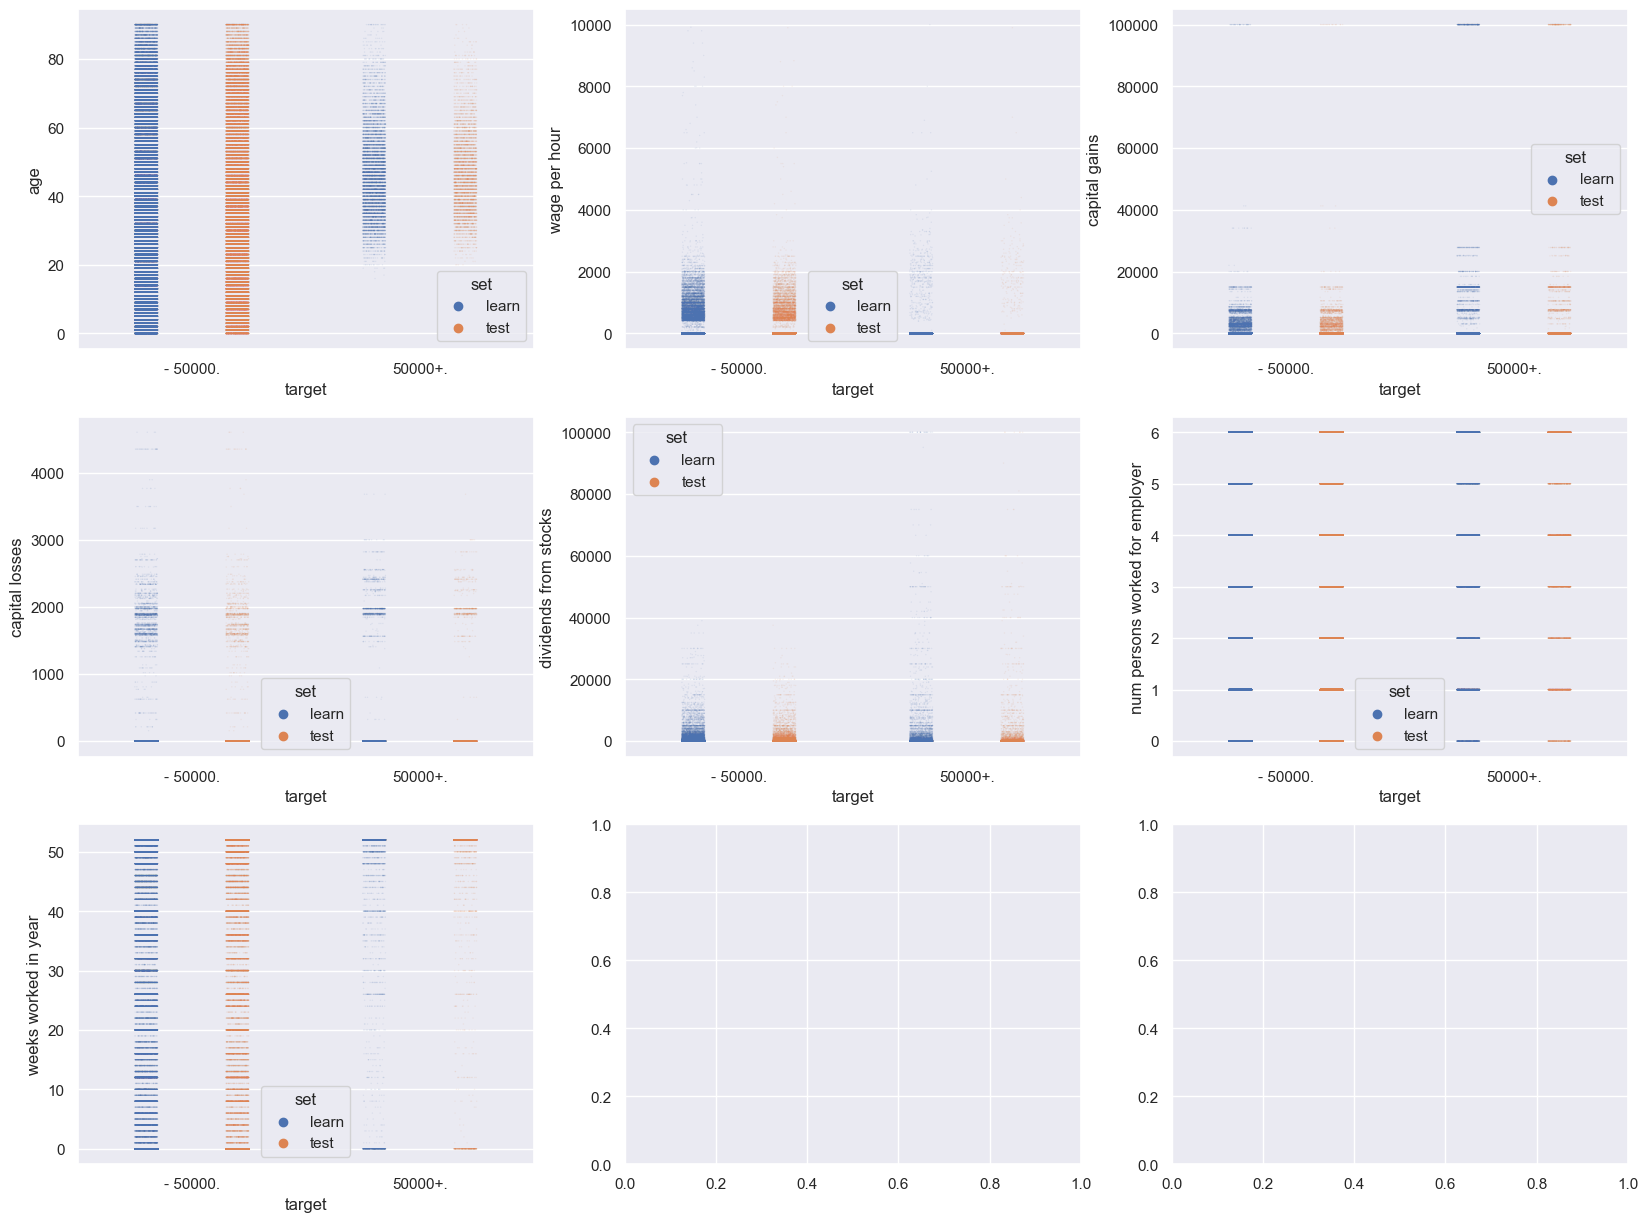

In [20]:
n_cols = 3
n_rows = int(np.ceil(len(numerical_cols) / n_cols))
_, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axs = axs.flatten()

for i, col in enumerate(numerical_cols):
    sns.stripplot(
        data=learn_test_df,
        x="target",
        y=col,
        hue="set",
        ax=axs[i],
        size=1,
        alpha=0.1,
        dodge=True,
    )

In [48]:
@interact(variable=categorical_cols)
def plot_target_proportion_vs_categorical(variable):
    plt.figure(figsize=(15, 4))
    sns.barplot(
        data=visualization.get_variable_crosstab(learn_df, test_df, variable),
        x=variable,
        y="Proportion of 50000+",
        hue="set",
        order=sorted(learn_df[variable].unique()),
    )
    plt.xticks(rotation=90)
    plt.show()

interactive(children=(Dropdown(description='variable', options=('class of worker', 'detailed industry recode',…

## Data modeling

In [180]:
# TODO: certaines features sont peut-être à laisser (ex: class of worker)
categorical_features = [
    # "class of worker",
    "detailed industry recode",
    "detailed occupation recode",
    "education",
    # "enroll in edu inst last wk",
    "marital stat",
    "major industry code",
    # "major occupation code",
    "race",
    "hispanic origin",
    "sex",
    # "member of a labor union",
    # "reason for unemployment",
    "full or part time employment stat",
    "tax filer stat",
    # "region of previous residence",
    # "state of previous residence",
    "detailed household and family stat",
    "detailed household summary in household",
    # "migration code-change in msa",
    # "migration code-change in reg",
    # "migration code-move within reg",
    "live in this house 1 year ago",
    # "migration prev res in sunbelt",
    # "family members under 18",
    "country of birth father",
    "country of birth mother",
    "country of birth self",
    "citizenship",
    "own business or self employed",
    # "fill inc questionnaire for veteran's admin",
    "veterans benefits",
]

numerical_features = [
    "age",
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "num persons worked for employer",
    "weeks worked in year",
]

In [181]:
X_train = learn_df[categorical_features + numerical_features].copy()
y_train = learn_df["target"]
X_test = test_df[categorical_features + numerical_features].copy()
y_test = test_df["target"].to_frame()

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [183]:
RANDOM_SEED = 2910

In [205]:
# Logistic regression pipeline
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_SEED,
)
lr_ct = ColumnTransformer(
    [
        (
            "scaler",
            StandardScaler(),
            numerical_features,
        ),
        (
            "onehot",
            OneHotEncoder(),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

lr_pipeline = Pipeline(
    steps=[
        ("col_trans", lr_ct),
        (
            "model",
            lr,
        ),
    ]
)

# Histogram gradient boosting pipeline
hgb = HistGradientBoostingClassifier(
    categorical_features=[X_train.columns.get_loc(col) for col in categorical_features],
    max_iter=500,
    class_weight="balanced",
    random_state=RANDOM_SEED,
)
hgb_ct = ColumnTransformer(
    [
        (
            "ordinal",
            OrdinalEncoder(),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

hgb_pipeline = Pipeline(
    steps=[
        ("col_trans", hgb_ct),
        (
            "model",
            hgb,
        ),
    ]
)

In [206]:
metrics_df = pd.DataFrame()
for model_name, pipeline in [
    ("logistic regression", lr_pipeline),
    ("histogram gradient boosting", hgb_pipeline),
]:
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    y_test[f"pred_{model_name}"] = pipeline.predict(X_test)

    precision, recall, f1, support = metrics.precision_recall_fscore_support(
        y_test["target"],
        y_test[f"pred_{model_name}"],
        average="binary",
        pos_label="50000+.",
    )
    metrics_df.loc[model_name, ["precision", "recall", "f1_score"]] = [
        precision,
        recall,
        f1,
    ]

Training logistic regression...
Training histogram gradient boosting...


In [203]:
metrics_df

,precision,recall,f1_score
logistic regression,0.283047,0.892014,0.429734
histogram gradient boosting,0.326966,0.891044,0.478389


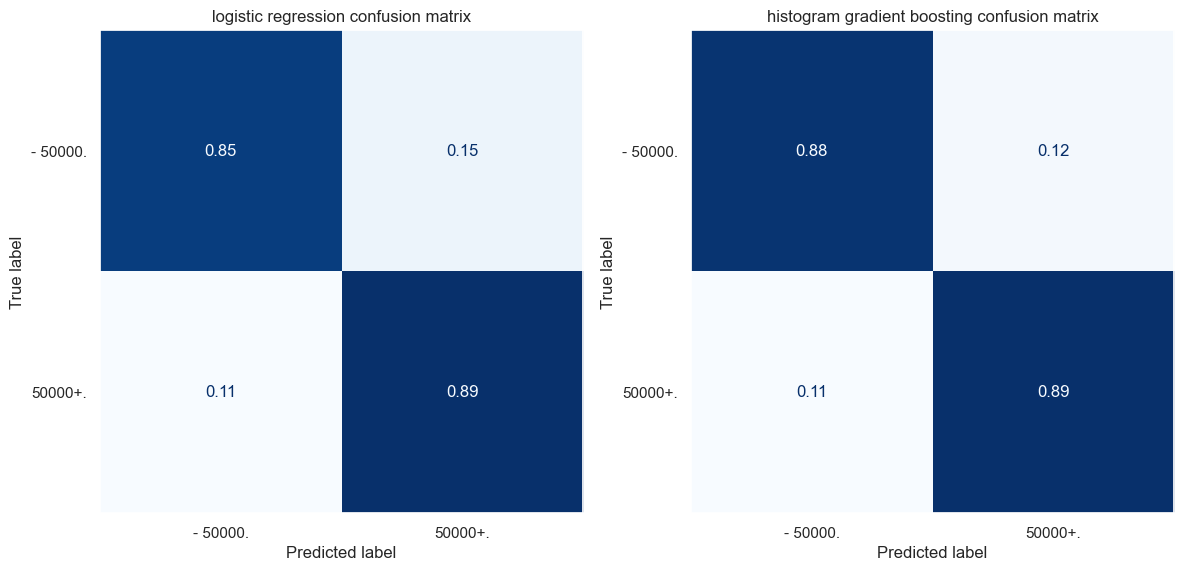

In [204]:
from sklearn.metrics import ConfusionMatrixDisplay

_, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, model_name in enumerate(["logistic regression", "histogram gradient boosting"]):
    ConfusionMatrixDisplay.from_predictions(
        y_test["target"],
        y_test[f"pred_{model_name}"],
        normalize="true",
        colorbar=False,
        cmap=plt.cm.Blues,  # type: ignore
        ax=axs[i],
    )
    axs[i].set_title(f"{model_name} confusion matrix")
    axs[i].grid(False)

plt.tight_layout()